In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn import svm
from sklearn import linear_model

from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

%matplotlib inline

In [3]:
arousal = pd.read_csv("../data/annotations/arousal_cont_average.csv", index_col = 0) # This will be our target
arousal = arousal.iloc[:,:-1] # We don't take the last timestamp, because some songs are slightly shorter
annotations = pd.read_csv("../data/annotations/songs_info.csv", index_col = 0)
annotations.Genre = annotations.Genre.str.strip()

train_ids = annotations.index[annotations["Mediaeval 2013 set"] == "development"]
test_ids = annotations.index[annotations["Mediaeval 2013 set"] == "evaluation"]

print(f"{len(train_ids)} train cases | {len(test_ids)} test cases")

619 train cases | 125 test cases


In [4]:
arousal

,sample_15000ms,sample_15500ms,sample_16000ms,sample_16500ms,sample_17000ms,sample_17500ms,sample_18000ms,sample_18500ms,sample_19000ms,sample_19500ms,...,sample_40000ms,sample_40500ms,sample_41000ms,sample_41500ms,sample_42000ms,sample_42500ms,sample_43000ms,sample_43500ms,sample_44000ms,sample_44500ms
song_id,,,,,,,,,,,,,,,,,,,,,
2,-0.109388,-0.114943,-0.116414,-0.118614,-0.126458,-0.133200,-0.136857,-0.144714,-0.138987,-0.137604,...,-0.256901,-0.259550,-0.262237,-0.261481,-0.264916,-0.265397,-0.265162,-0.264470,-0.265842,-0.267091
3,-0.110847,-0.123974,-0.131104,-0.135957,-0.140777,-0.144664,-0.163118,-0.165218,-0.158859,-0.156783,...,-0.265676,-0.265929,-0.263960,-0.263571,-0.262956,-0.260337,-0.248710,-0.245516,-0.251299,-0.254619
4,0.222328,0.179448,0.178389,0.184057,0.176043,0.178720,0.176345,0.175793,0.176155,0.176605,...,0.309625,0.298644,0.294144,0.302703,0.297487,0.303424,0.298097,0.304340,0.304115,0.305079
5,-0.255613,-0.251578,-0.251957,-0.251123,-0.250762,-0.251957,-0.251957,-0.251957,-0.251957,-0.251957,...,-0.222826,-0.225898,-0.228913,-0.228913,-0.228913,-0.228913,-0.227561,-0.227609,-0.229996,-0.243920
7,0.464233,0.460788,0.460990,0.461046,0.457239,0.465701,0.471808,0.469918,0.473376,0.470050,...,0.331689,0.333163,0.331243,0.333927,0.333740,0.340782,0.339002,0.339271,0.340961,0.342020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.083658,-0.079965,-0.080614,-0.077533,-0.081066,-0.082564,-0.075276,-0.071917,-0.072352,-0.073255,...,-0.047891,-0.046469,-0.044649,-0.041990,-0.035563,-0.037822,-0.040367,-0.043850,-0.049861,-0.046132
996,0.340385,0.339627,0.340270,0.335955,0.338222,0.335331,0.340030,0.343517,0.347987,0.352064,...,0.361213,0.364017,0.366737,0.366231,0.366730,0.365032,0.366610,0.367975,0.370551,0.369909
997,0.367088,0.368839,0.352861,0.311679,0.278800,0.253148,0.249393,0.243813,0.238716,0.240276,...,0.245477,0.257732,0.293368,0.312197,0.327872,0.337830,0.332809,0.332175,0.337198,0.353745


In [53]:
STEP = 0.05

df = pd.read_csv("../data/paa_features/2.csv")
df = df.iloc[int(14.5 / STEP) + 1:int(44.5 / STEP) + 1,:-2] # Our desired timerange + ommiting timestamps and song IDs
X = df.to_numpy()

frames_per_X = int(len(X) * STEP / 0.5) # 0.5 is our frequency of y

X_stack = np.stack(np.split(X, frames_per_X)) 
X_stack.mean(axis = 1).shape
X_stack.std(axis = 1).shape
X = np.concatenate([X_stack.mean(axis = 1), X_stack.std(axis = 1)], axis = 1)
X.shape

(60, 136)

In [16]:
def load_X(ids):
    X_raw = []

    for i in ids:
        df = pd.read_csv(f"../data/paa_features/{i}.csv")
        df = df.iloc[int(14.5 / STEP) + 1:int(44.5 / STEP) + 1,:-2] # Our desired timerange + ommiting timestamps and song IDs
        X = df.to_numpy()

        frames_per_X = int(len(X) * STEP / 0.5) # 0.5 is our frequency of y
        X = np.stack(np.split(X, frames_per_X)).mean(axis = 1)

        assert X.shape == (60, 68)

        X_raw.append(X)

    X_raw = np.concatenate(X_raw)
    return X_raw

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [11]:
X_raw = []

for i in train_ids:
    df = pd.read_csv(f"../data/paa_features/{i}.csv")
    df = df.iloc[int(14.5 / STEP) + 1:int(44.5 / STEP) + 1,:-2] # Our desired timerange + ommiting timestamps and song IDs
    X = df.to_numpy()

    frames_per_X = int(len(X) * STEP / 0.5) # 0.5 is our frequency of y
    X = np.stack(np.split(X, frames_per_X)).mean(axis = 1)
    
    assert X.shape == (60, 68)
    
    X_raw.append(X)
    
X_raw = np.concatenate(X_raw)
X_raw.shape

(37140, 68)

In [12]:
y_train = arousal.loc[train_ids].to_numpy().flatten()
y_train.shape

(37140,)

In [17]:
X_test_raw = load_X(test_ids)
X_test_raw.shape

(7500, 68)

In [18]:
y_test = arousal.loc[test_ids].to_numpy().flatten()
y_test.shape

(7500,)

# Scaling

In [19]:
scaler = StandardScaler()
scaler.fit(X_raw)
X_train = scaler.transform(X_raw)
X_test = scaler.transform(X_test_raw)

print(X_train.mean(axis = 0), X_train.std(axis = 0))

[ 3.48151248e-15 -1.33867480e-15 -1.10473648e-13  1.36455946e-14
  4.74429223e-14  5.60935849e-15 -8.13971041e-15  6.57893832e-16
  1.16654128e-15 -1.19114615e-15  2.26781885e-16 -1.84113181e-15
  2.39648545e-16  1.85405452e-15 -4.78809836e-16  6.09259546e-16
  5.79770181e-16  3.31536390e-16 -4.36269969e-16 -2.53611528e-17
  1.90218361e-16  1.03891976e-14  7.35382257e-16 -3.41844963e-15
 -4.77416676e-15  7.32143509e-15 -3.51647300e-15 -7.12583824e-15
 -3.52739363e-15  2.75652773e-15 -9.81813954e-15 -3.13293414e-15
  1.95557535e-15 -1.17965232e-15  2.34973293e-17 -1.93108259e-18
 -7.60700065e-18 -3.67981837e-18  9.48203402e-18  4.14315862e-18
 -1.73109896e-17 -6.48676350e-18 -4.13658218e-17  1.45492575e-17
  1.74178568e-17  1.46415519e-17 -2.09071078e-17 -5.87694794e-18
 -5.19314741e-18  1.31708203e-17  6.70199252e-18  1.34846959e-17
 -4.23582667e-18  2.71771476e-17 -1.27381203e-17 -5.27908956e-18
 -2.97882941e-18  8.34572942e-18  1.65008915e-18 -1.39002075e-17
  7.19522569e-18 -6.89330

In [12]:
y_train = arousal.loc[train_ids].to_numpy().flatten()
y_train.shape

(37140,)

In [17]:
X_test_raw = load_X(test_ids)
X_test_raw.shape

(7500, 68)

In [18]:
y_test = arousal.loc[test_ids].to_numpy().flatten()
y_test.shape

(7500,)

# SVR

In [14]:
svr = svm.SVR(cache_size = 4000)
svr.fit(X_train, y_train)

SVR(cache_size=4000)

In [15]:
sqrt(mean_squared_error(y_train, svr.predict(X_train)))

0.11329075226580547

In [46]:
y_predict = svr.predict(X_test)
sqrt(mean_squared_error(y_test, y_predict))

0.22701809523116498

In [47]:
r2_score(y_test, y_predict)

0.36844609801264916

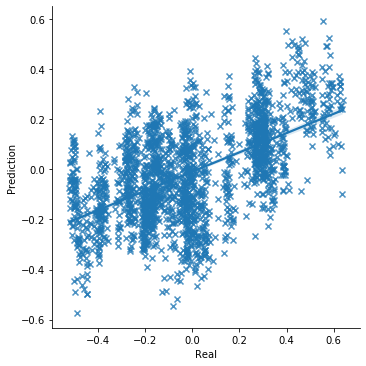

In [48]:
lm_df = pd.DataFrame({"Real": y_test, "Prediction": y_predict})
sns.lmplot(data = lm_df[:2000], x = "Real", y = "Prediction", markers = "x")

# What if we add stds?

It improves the results slightly (but still does)

R2:  0.37 -> 0.39

In [54]:
def load_X(ids):
    X_raw = []

    for i in ids:
        df = pd.read_csv(f"../data/paa_features/{i}.csv")
        df = df.iloc[int(14.5 / STEP) + 1:int(44.5 / STEP) + 1,:-2] # Our desired timerange + ommiting timestamps and song IDs
        X = df.to_numpy()

        frames_per_X = int(len(X) * STEP / 0.5) # 0.5 is our frequency of y
        X_stack = np.stack(np.split(X, frames_per_X))
        X = np.concatenate([X_stack.mean(axis = 1), X_stack.std(axis = 1)], axis = 1)


        assert X.shape == (60, 136)

        X_raw.append(X)

    X_raw = np.concatenate(X_raw)
    return X_raw

In [56]:
X_raw = load_X(train_ids)
X_raw.shape

(37140, 136)

In [57]:
y_train = arousal.loc[train_ids].to_numpy().flatten()
y_train.shape

(37140,)

In [58]:
X_test_raw = load_X(test_ids)
X_test_raw.shape

(7500, 136)

In [59]:
y_test = arousal.loc[test_ids].to_numpy().flatten()
y_test.shape

(7500,)

In [60]:
scaler = StandardScaler()
scaler.fit(X_raw)
X_train = scaler.transform(X_raw)
X_test = scaler.transform(X_test_raw)

print(X_train.mean(axis = 0), X_train.std(axis = 0))

[ 3.48151248e-15 -1.33867480e-15 -1.10473648e-13  1.36455946e-14
  4.74429223e-14  5.60935849e-15 -8.13971041e-15  6.57893832e-16
  1.16654128e-15 -1.19114615e-15  2.26781885e-16 -1.84113181e-15
  2.39648545e-16  1.85405452e-15 -4.78809836e-16  6.09259546e-16
  5.79770181e-16  3.31536390e-16 -4.36269969e-16 -2.53611528e-17
  1.90218361e-16  1.03891976e-14  7.35382257e-16 -3.41844963e-15
 -4.77416676e-15  7.32143509e-15 -3.51647300e-15 -7.12583824e-15
 -3.52739363e-15  2.75652773e-15 -9.81813954e-15 -3.13293414e-15
  1.95557535e-15 -1.17965232e-15  2.34973293e-17 -1.93108259e-18
 -7.60700065e-18 -3.67981837e-18  9.48203402e-18  4.14315862e-18
 -1.73109896e-17 -6.48676350e-18 -4.13658218e-17  1.45492575e-17
  1.74178568e-17  1.46415519e-17 -2.09071078e-17 -5.87694794e-18
 -5.19314741e-18  1.31708203e-17  6.70199252e-18  1.34846959e-17
 -4.23582667e-18  2.71771476e-17 -1.27381203e-17 -5.27908956e-18
 -2.97882941e-18  8.34572942e-18  1.65008915e-18 -1.39002075e-17
  7.19522569e-18 -6.89330

In [61]:
svr = svm.SVR(cache_size = 4000)
svr.fit(X_train, y_train)

SVR(cache_size=4000)

In [62]:
sqrt(mean_squared_error(y_train, svr.predict(X_train)))

0.10146547616174452

In [63]:
y_predict = svr.predict(X_test)
sqrt(mean_squared_error(y_test, y_predict))

0.22303762090292148

In [64]:
r2_score(y_test, y_predict)

0.390398931392382

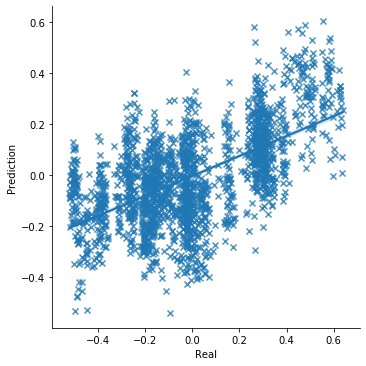

In [65]:
lm_df = pd.DataFrame({"Real": y_test, "Prediction": y_predict})
sns.lmplot(data = lm_df[:2000], x = "Real", y = "Prediction", markers = "x")